In [7]:
from pylab import * 
import numpy as np
import matplotlib as mtp
import matplotlib.pyplot as plt
from sklearn import *

In [8]:
# Projektaufgaben
#1 Daten importieren
#2 Aus den Daten Linearen Plot auslesen
#3 linearen fit entfernen
#4 plot oben und unten mitteln
#5 Volt Werte zu Polarisation umwandeln

In [9]:
#Datenimport Erste Probe

#Faraday
fd1flux = genfromtxt(fname="../Erste Probe/faraday1/all_data.txt", delimiter="",dtype=None, usecols=0)
fd1voltage = genfromtxt(fname="../Erste Probe/faraday1/all_data.txt", delimiter="",dtype=None, usecols=1)
fd1std = genfromtxt(fname="../Erste Probe/faraday1/all_data.txt", delimiter="",dtype=None, usecols=2)

#faraday1diodecalibration
polangle1 = genfromtxt(fname="../Erste Probe/calibfara/diode_calibration.txt", delimiter="",dtype=None, usecols=0)
diodevoltage1 = genfromtxt(fname="../Erste Probe/calibfara/diode_calibration.txt", delimiter="",dtype=None, usecols=1)
diodestd1 = genfromtxt(fname="../Erste Probe/calibfara/diode_calibration.txt", delimiter="",dtype=None, usecols=2)

#kerrmethod1
kerr1flux = genfromtxt(fname="../Erste Probe/kerr-messung1/all_data.txt", delimiter="",dtype=None, usecols=0)
kerr1voltage = genfromtxt(fname="../Erste Probe/kerr-messung1/all_data.txt", delimiter="",dtype=None, usecols=1)
kerr1std = genfromtxt(fname="../Erste Probe/kerr-messung1/all_data.txt", delimiter="",dtype=None, usecols=2)

#kerrmethod2
kerr2flux = genfromtxt(fname="../Erste Probe/kerr-messung2/all_data.txt", delimiter="",dtype=None, usecols=0)
kerr2voltage = genfromtxt(fname="../Erste Probe/kerr-messung2/all_data.txt", delimiter="",dtype=None, usecols=1)
kerr2std = genfromtxt(fname="../Erste Probe/kerr-messung2/all_data.txt", delimiter="",dtype=None, usecols=2)

#faraday1diodecalibration
polangle2 = genfromtxt(fname="../Erste Probe/calibrationkerrmethod/diode_calibration.txt", delimiter="",dtype=None, usecols=0)
diodevoltage2 = genfromtxt(fname="../Erste Probe/calibrationkerrmethod/diode_calibration.txt", delimiter="",dtype=None, usecols=1)
diodestd2 = genfromtxt(fname="../Erste Probe/calibrationkerrmethod/diode_calibration.txt", delimiter="",dtype=None, usecols=2)



#Datenimport zweite Probe
#Faraday
fd2flux = genfromtxt(fname="../Zweite Probe/faraday/all_data.txt", delimiter="",dtype=None, usecols=0)
fd2voltage = genfromtxt(fname="../Zweite Probe/faraday/all_data.txt", delimiter="",dtype=None, usecols=1)
fd2std = genfromtxt(fname="../Zweite Probe/faraday/all_data.txt", delimiter="",dtype=None, usecols=2)
#faraday1diodecalibration
polangle3 = genfromtxt(fname="../Zweite Probe/faraday/diode_calibration.txt", delimiter="",dtype=None, usecols=0)
diodevoltage3 = genfromtxt(fname="../Zweite Probe/faraday/diode_calibration.txt", delimiter="",dtype=None, usecols=1)
diodestd3 = genfromtxt(fname="../Zweite Probe/faraday/diode_calibration.txt", delimiter="",dtype=None, usecols=2)



In [11]:
#Genauigkeit eines linearen Fits ab Wert n berechnen und ausgeben
def calibratelinearfit(x,y,weight,n, precision):
    """Funktion zur Berechnung des linearen Fits, der die eigentliche Probenmessung verzerrt. n gibt an wie viele Werte übersprungen werden sollen am Anfang.
    precision gibt die minimale Größe der Varianz an"""
    for i in range(n+2,len(x)):
            reg = linear_model.LinearRegression()
            xres = x[n:i].reshape(-1,1)
            reg.fit(xres,y[n:i], sample_weight=1/weight[n:i])
            m = reg.coef_
            b = reg.intercept_
            rscore = reg.score(xres, y[n:i])
            if precision>rscore:
                plt.plot(xres, y[n:i])
                plt.plot(xres, m*xres+b)
                print(rscore,i)
                break

In [12]:
#Neue Werte berechnen für einen Fit von n bis k (Linearen Fit rausrechnen)
def newfluxcalc(x,y,weight,c1,c2,c3,n,k):
    #Linearen Plot rausrechnen
    reg = linear_model.LinearRegression()
    xres = x[n:k].reshape(-1,1)
    reg.fit(xres,y[n:k],sample_weight=1/weight[n:k])
    m = reg.coef_
    b = reg.intercept_
    newy = y-(m*x+b)

    #Werte um die x-Achse mitteln
    midvalue = sum(newy)/len(newy)
    newval = newy-midvalue

    #Linearer Fit zur Kalibration Voltage - Winkel
    reg1 = linear_model.LinearRegression()
    calib = c2.reshape(-1,1)
    reg1.fit(calib,c1,sample_weight=1/c3)
    m1 = reg1.coef_
    b1 = reg1.intercept_
    ypol = m1*newval+b1


    fig= plt.figure()
    ax2 = fig.add_subplot()

    ax1 = ax2.twinx()
    color = "tab:red"
    ax1.set_xlabel("Magnetische Flussdichte B in mT")
    ax1.set_ylabel("Diodenspannung in V", color=color)
    ax1.plot(x,newval, color=color)
    ax1.tick_params(axis="y",labelcolor = color)
    
    color = "tab:green"
    ax2.set_ylabel(r"Polarisationswinkel $\theta$ in°",color = color)
    ax2.plot(x,ypol, color = color)
    ax2.tick_params(axis="y",labelcolor = color)
    ax2.grid()

    plt.title("Änderung der Polarisation in Abh. des B-Felds")
    plt.show()

0.9397548703948252 89


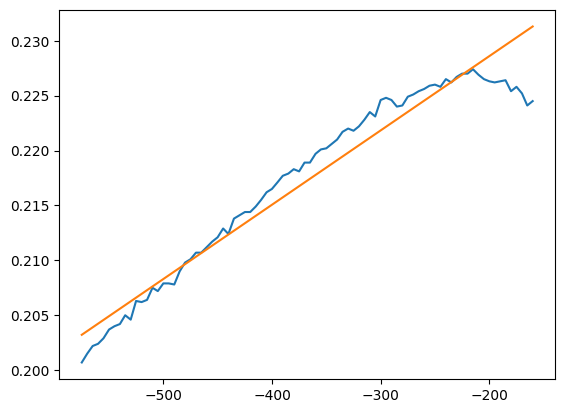

In [13]:
calibratelinearfit(fd1flux, fd1voltage,fd1std, 5,0.945)

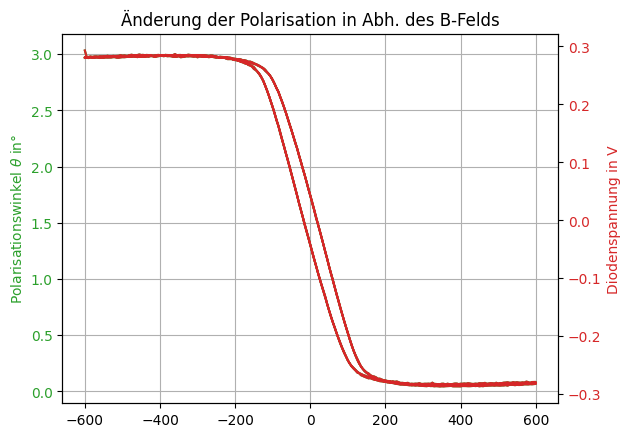

In [39]:
newy = newfluxcalc(fd1flux, fd1voltage,fd1std, polangle1, diodevoltage1, diodestd1, 5,80)

0.925968024363965 104


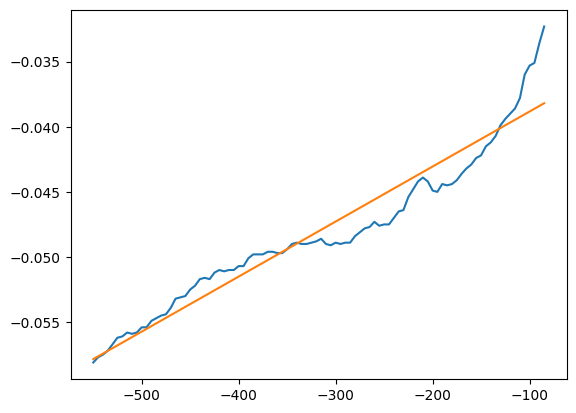

In [15]:
calibratelinearfit(kerr1flux,kerr1voltage,kerr1std, 10, 0.93)

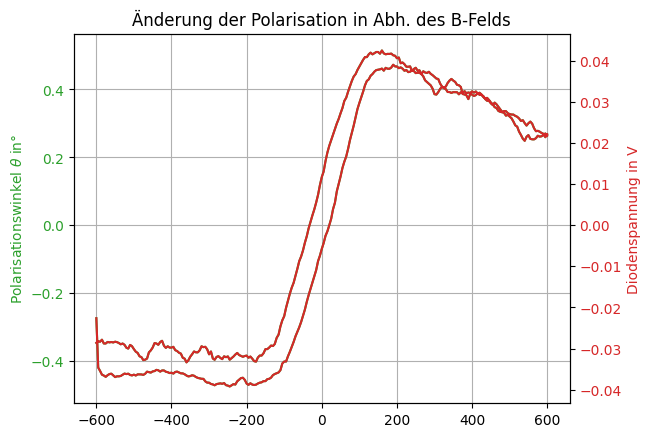

In [16]:
newfluxcalc(kerr1flux , kerr1voltage,kerr1std, polangle2, diodevoltage2, diodestd2, 10, 104)

0.7756910886351551 7


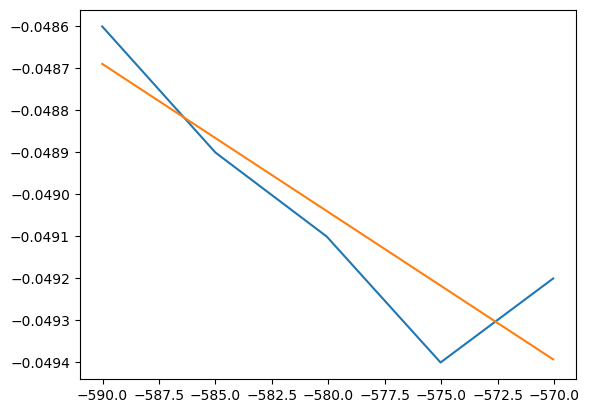

In [34]:
calibratelinearfit(kerr2flux, kerr2voltage, kerr2std,2,0.8)

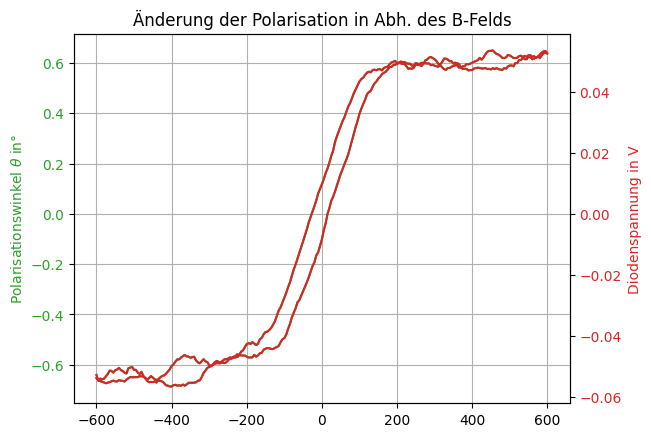

In [38]:
newfluxcalc(kerr2flux , kerr2voltage,kerr2std, polangle2, diodevoltage2, diodestd2, 2, 60)

0.5167455113063133 5


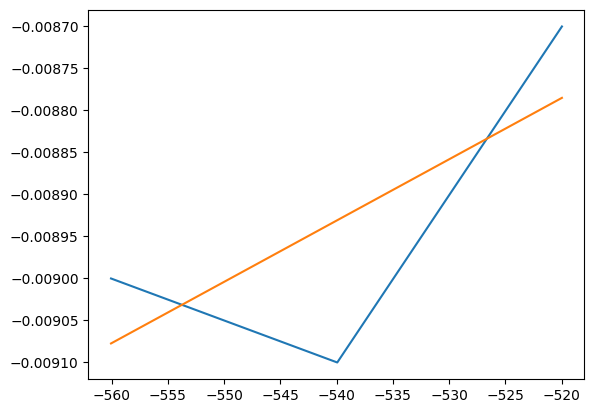

In [30]:
calibratelinearfit(fd2flux,fd2voltage,fd2std,2,0.9)

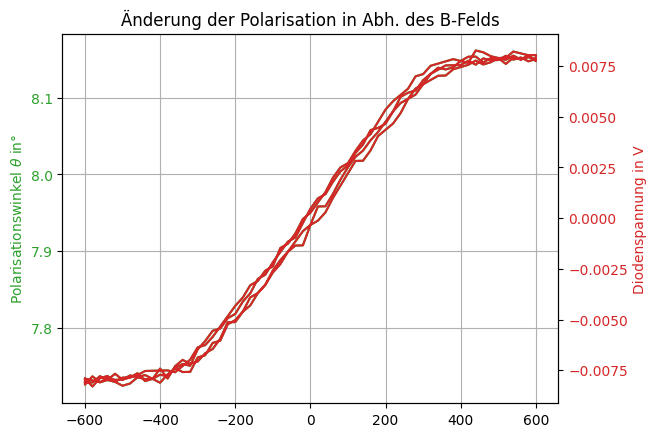

In [29]:
newfluxcalc(fd2flux,fd2voltage,fd2std, polangle3,diodevoltage3,diodestd3, 2,10)